# Team Defense Analysis

This notebook analyzes which defensive weaknesses exist for a specific team.

We will:
- Load and preprocess event data
- Filter for defense perspective (opponent acts as attacker against target team)
- Identify zones with high success rates for opponent attacks
- Visualize defensive vulnerabilities


In [64]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
from src.data_loader import load_raw_events, load_match_info
from src.feature_engineering import add_zone_columns, filter_team_vs_opponent
from src.analysis_utils import compute_zone_success_rate, compute_team_zone_profile

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Team name mapping (Korean -> English for plots)
TEAM_NAME_EN_MAP = {
    'FC서울': 'FC Seoul',
    '김천 상무 프로축구단': 'Gimcheon Sangmu FC',
    '울산 HD FC': 'Ulsan HD FC',
    '수원FC': 'Suwon FC',
    '포항 스틸러스': 'Pohang Steelers',
    '전북 현대 모터스': 'Jeonbuk Hyundai Motors',
    '제주SK FC': 'Jeju United FC',
    '강원FC': 'Gangwon FC',
    '대구FC': 'Daegu FC',
    '인천 유나이티드': 'Incheon United',
    '광주FC': 'Gwangju FC',
    '대전 하나 시티즌': 'Daejeon Hana Citizen'
}

def get_team_name_en(team_name_ko):
    """Convert Korean team name to English for plots."""
    return TEAM_NAME_EN_MAP.get(team_name_ko, team_name_ko)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration


In [65]:
# TODO: Adapt to real team names/IDs from the dataset
TARGET_TEAM = get_team_name_en("울산 HD FC")  # TODO: Update with actual team identifier

# Perspective: defense (opponent acts as attacker)
AS_DEFENDER = True


## Data Loading & Preprocessing


In [66]:
# Load raw data
events = load_raw_events()
match_info = load_match_info()

print(f"Total events: {len(events)}")
print(f"Total matches: {len(match_info)}")

# Check available teams
print("\n" + "="*50)
print("Available teams in events:")
print(events['team_name_ko'].value_counts().head(20))
print("\n" + "="*50)
print("Available teams in match_info:")
all_teams = pd.concat([match_info['home_team_name_ko'], match_info['away_team_name_ko']]).unique()
print(sorted(all_teams))


Total events: 579306
Total matches: 198

Available teams in events:
team_name_ko
울산 HD FC       53492
광주FC           51701
FC서울           50233
포항 스틸러스        49779
수원FC           49075
강원FC           48150
인천 유나이티드       48136
김천 상무 프로축구단    47714
전북 현대 모터스      47032
제주SK FC        45551
대전 하나 시티즌      45131
대구FC           43312
Name: count, dtype: int64

Available teams in match_info:
['FC서울', '강원FC', '광주FC', '김천 상무 프로축구단', '대구FC', '대전 하나 시티즌', '수원FC', '울산 HD FC', '인천 유나이티드', '전북 현대 모터스', '제주SK FC', '포항 스틸러스']


In [67]:
# Add zone columns
events = add_zone_columns(
    events,
    x_col="start_x",
    y_col="start_y",
)

print("Zones added. Sample:")
print(events[["zone", "start_x", "start_y"]].head())


Zones added. Sample:
   zone    start_x    start_y
0  AM-C  52.670205  34.919632
1  AM-C  68.628945  34.347412
2  AM-C  68.228055  33.853256
3  AM-C  65.468865  26.640292
4  AM-C  64.838025  26.766636


In [68]:
# Filter for defense perspective (opponent acts as attacker against target team)
defense_events = filter_team_vs_opponent(
    events,
    team_col="team_id",
    target_team=TARGET_TEAM,
    as_defender=AS_DEFENDER,
    match_info=match_info,
    team_name_en_map=TEAM_NAME_EN_MAP,
)

print(f"Defense events (against {TARGET_TEAM}): {len(defense_events)}")
print(f"Percentage of total events: {len(defense_events) / len(events) * 100:.2f}%")


Defense events (against Ulsan HD FC): 44700
Percentage of total events: 7.72%


## Defensive Weaknesses by Zone


In [69]:
# Compute zone success rate for opponent attacks
if len(defense_events) > 0:
    success_by_zone = compute_zone_success_rate(
        defense_events,
        event_type_col="type_name",
        outcome_col="result_name",
    )
    
    # Filter for key attacking events
    key_events = ["Pass", "Shot"]
    success_filtered = success_by_zone[success_by_zone["event_type"].isin(key_events)]
    
    print("Opponent Success Rate by Zone (Defensive Weaknesses):")
    print(success_filtered.sort_values("success_rate", ascending=False).head(20))
else:
    print("No defense events found. Check team filtering.")


Opponent Success Rate by Zone (Defensive Weaknesses):
       zone event_type  attempts  success  success_rate
244   D-nan       Pass         2        2      1.000000
101    AM-C       Pass      1410     1287      0.912766
259    DM-C       Pass      1461     1317      0.901437
123    AM-L       Pass      1607     1401      0.871811
144    AM-R       Pass      1818     1573      0.865237
282    DM-L       Pass      1786     1545      0.865062
305    DM-R       Pass      1760     1513      0.859659
155  AM-nan       Pass         7        6      0.857143
232     D-R       Pass       483      406      0.840580
48      A-L       Pass       550      456      0.829091
181     D-C       Pass       634      500      0.788644
23      A-C       Pass       691      543      0.785818
74      A-R       Pass       642      501      0.780374
207     D-L       Pass       661      504      0.762481
322  DM-nan       Pass        10        7      0.700000
187     D-C       Shot       116       15      0.1

## Distribution of Shots / Key Events Against This Team


In [70]:
# Count shots and key events by zone
if len(defense_events) > 0:
    shot_events = defense_events[defense_events["type_name"] == "Shot"]
    
    print(f"Total shots against {TARGET_TEAM}: {len(shot_events)}")
    if len(shot_events) > 0:
        print("\nShots by zone:")
        print(shot_events["zone"].value_counts())
        
        print(f"\nTotal passes against {TARGET_TEAM}: {len(defense_events[defense_events['type_name'] == 'Pass'])}")
        print(f"Total crosses against {TARGET_TEAM}: {len(defense_events[defense_events['type_name'] == 'Cross'])}")
else:
    print("No defense events found.")


Total shots against Ulsan HD FC: 333

Shots by zone:
zone
D-C     116
A-C     103
A-R      25
A-L      22
D-L      22
D-R      21
DM-C     12
AM-C     10
DM-L      1
DM-R      1
Name: count, dtype: int64

Total passes against Ulsan HD FC: 13525
Total crosses against Ulsan HD FC: 457


## Visualizations

### 1. Zone별 성공률 막대 그래프


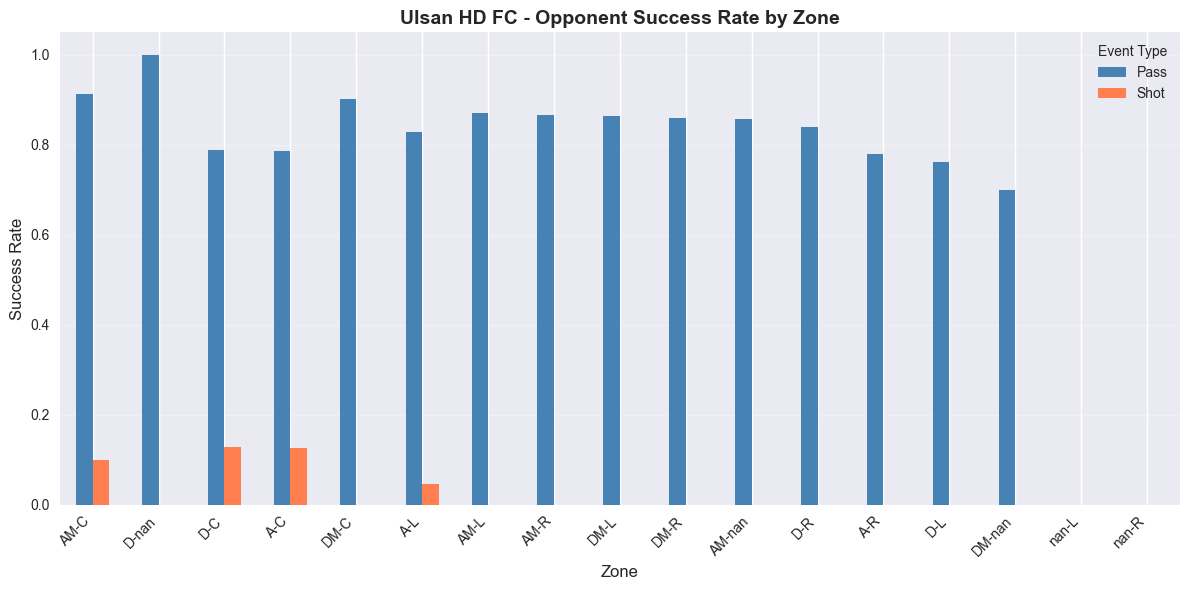

In [71]:
# Bar chart of success rates by zone
if len(defense_events) > 0:
    success_by_zone = compute_zone_success_rate(
        defense_events,
        event_type_col="type_name",
        outcome_col="result_name",
    )
    
    # Filter for key events
    key_events = ["Pass", "Shot"]
    success_filtered = success_by_zone[success_by_zone["event_type"].isin(key_events)]
    
    if len(success_filtered) > 0:
        # Remove NaN zones
        success_filtered = success_filtered[success_filtered["zone"].notna()].copy()
        
        # Create pivot table for easier plotting
        pivot_success = success_filtered.pivot_table(
            values='success_rate',
            index='zone',
            columns='event_type',
            fill_value=0
        )
        
        # Sort by total success rate
        pivot_success['total'] = pivot_success.sum(axis=1)
        pivot_success = pivot_success.sort_values('total', ascending=False).drop('total', axis=1)
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        pivot_success.plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
        ax.set_xlabel('Zone', fontsize=12)
        ax.set_ylabel('Success Rate', fontsize=12)
        ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Opponent Success Rate by Zone', fontsize=14, fontweight='bold')
        ax.legend(title='Event Type', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No success rate data available for visualization.")
else:
    print("No defense events found.")


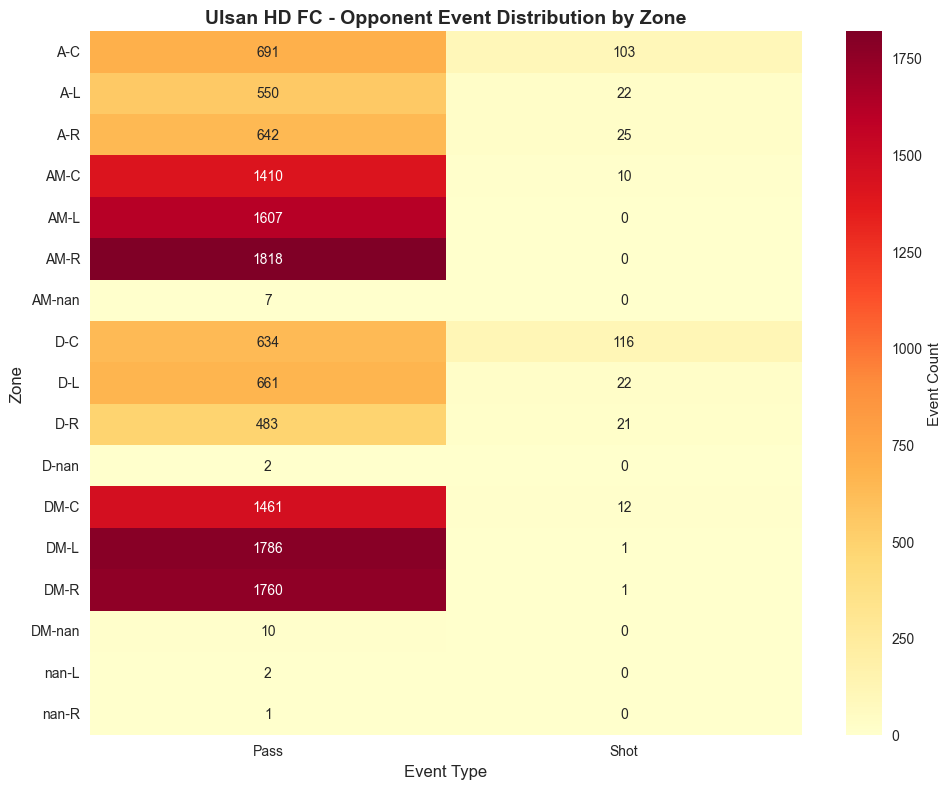

In [72]:
# Heatmap of event distribution by zone
if len(defense_events) > 0:
    # Group by zone and event type
    zone_event_counts = defense_events.groupby(['zone', 'type_name']).size().reset_index(name='event_count')
    
    # Filter for key events
    key_events = ["Pass", "Shot"]
    zone_event_counts = zone_event_counts[zone_event_counts['type_name'].isin(key_events)]
    
    # Remove NaN zones
    zone_event_counts = zone_event_counts[zone_event_counts['zone'].notna()].copy()
    
    if len(zone_event_counts) > 0:
        # Create pivot table
        zone_pivot = zone_event_counts.pivot_table(
            values='event_count',
            index='zone',
            columns='type_name',
            fill_value=0
        )
        
        # Sort zones logically (if possible)
        try:
            # Try to sort by zone name (e.g., D-L, D-C, D-R, DM-L, etc.)
            zone_order = sorted(zone_pivot.index, key=lambda x: (x.split('-')[0], x.split('-')[1] if '-' in x else ''))
            zone_pivot = zone_pivot.reindex(zone_order)
        except:
            pass
        
        # Convert to int for display (event counts should be integers)
        zone_pivot_int = zone_pivot.astype(int)
        
        # Plot heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(zone_pivot_int, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Event Count'})
        ax.set_xlabel('Event Type', fontsize=12)
        ax.set_ylabel('Zone', fontsize=12)
        ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Opponent Event Distribution by Zone', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("No event distribution data available for visualization.")
else:
    print("No defense events found.")


### 3. 상대팀 패스 맵 시각화


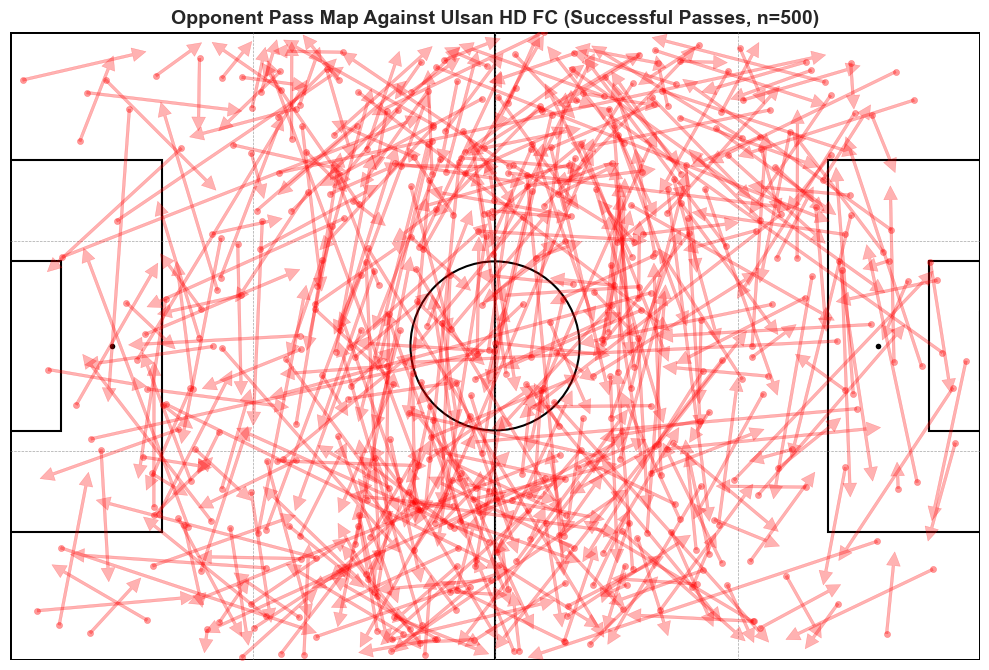

In [73]:
# Opponent pass map visualization
if len(defense_events) > 0:
    from src.pitch_plot import draw_pitch, plot_pass_arrows, add_zones_to_ax
    
    # Filter for successful passes only
    passes = defense_events[
        (defense_events['type_name'] == 'Pass') & 
        (defense_events['result_name'] == 'Successful')
    ].copy()
    
    if len(passes) > 0:
        # Sample passes if too many (for performance)
        sample_size = min(500, len(passes))
        passes_sample = passes.sample(n=sample_size, random_state=42) if len(passes) > sample_size else passes
        
        # Remove NaN coordinates
        passes_sample = passes_sample[
            passes_sample['start_x'].notna() & 
            passes_sample['start_y'].notna() &
            passes_sample['end_x'].notna() & 
            passes_sample['end_y'].notna()
        ].copy()
        
        if len(passes_sample) > 0:
            fig, ax = plt.subplots(figsize=(10, 14))
            draw_pitch(ax=ax, show=False)
            add_zones_to_ax(ax)
            
            # Ensure axes limits are set correctly
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            # Plot pass start positions as dots
            ax.scatter(
                passes_sample['start_x'],
                passes_sample['start_y'],
                c='red',
                alpha=0.4,
                s=20,
                zorder=2
            )
            
            # Plot pass arrows
            ax = plot_pass_arrows(
                passes_sample,
                ax=ax,
                x_start_col="start_x",
                y_start_col="start_y",
                x_end_col="end_x",
                y_end_col="end_y",
                color="red",
                alpha=0.3,
                arrow_width=0.3,
                head_width=1.5,
                head_length=1.5,
                draw_pitch_flag=False,
                max_arrows=500,
            )
            
            # Ensure axes limits again after plotting
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            ax.set_title(f'Opponent Pass Map Against {get_team_name_en(TARGET_TEAM)} (Successful Passes, n={len(passes_sample)})', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("No passes with valid coordinates found.")
    else:
        print("No successful passes found.")
else:
    print("No defense events available.")


### 4. 상대팀 슛 위치 플롯


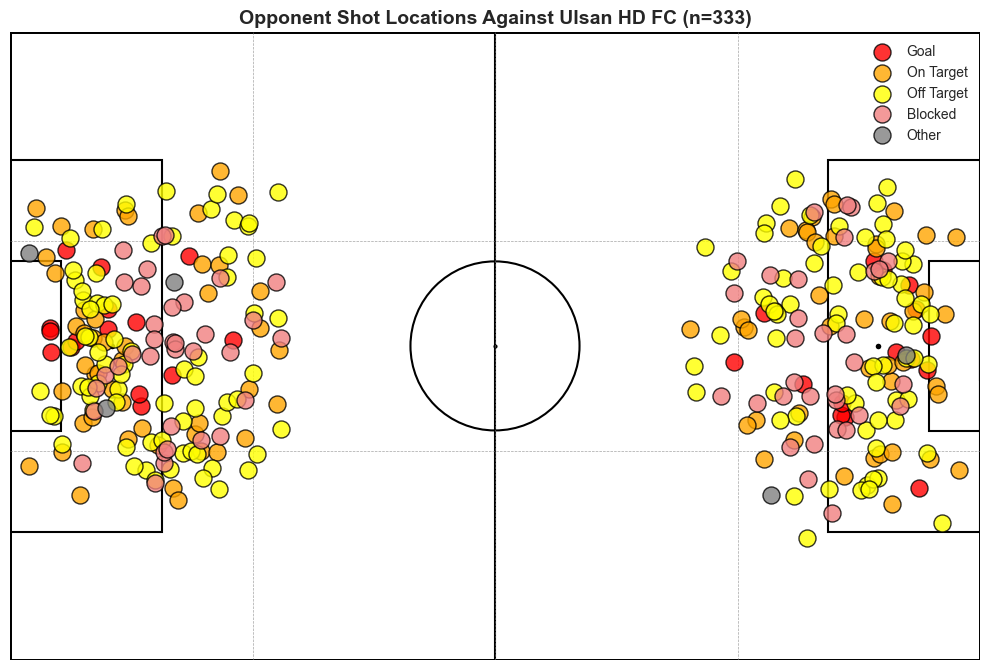


Shot Statistics Against Ulsan HD FC:
shot_result
Off Target    140
On Target      91
Blocked        67
Goal           30
Other           5
Name: count, dtype: int64

Goal Rate: 9.01%


In [74]:
# Opponent shot location plot on pitch
if len(defense_events) > 0:
    from src.pitch_plot import draw_pitch, add_zones_to_ax
    
    # Filter for shots
    shots = defense_events[defense_events['type_name'] == 'Shot'].copy()
    
    if len(shots) > 0:
        # Create result category for coloring
        shots['shot_result'] = shots['result_name'].fillna('Other')
        # Keep Goal, On Target, Off Target, Blocked as is, others as 'Other'
        shots.loc[~shots['shot_result'].isin(['Goal', 'On Target', 'Off Target', 'Blocked']), 'shot_result'] = 'Other'
        
        # Create color mapping
        result_colors = {
            'Goal': 'red',
            'On Target': 'orange',
            'Off Target': 'yellow',
            'Blocked': 'lightcoral',
            'Other': 'gray'
        }
        
        # Remove NaN coordinates
        shots_clean = shots[
            shots['start_x'].notna() & 
            shots['start_y'].notna()
        ].copy()
        
        if len(shots_clean) > 0:
            fig, ax = plt.subplots(figsize=(10, 14))
            draw_pitch(ax=ax, show=False)
            add_zones_to_ax(ax)
            
            # Ensure axes limits are set correctly
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            # Plot shots colored by result - plot each category separately for better legend
            for result, color in result_colors.items():
                shots_result = shots_clean[shots_clean['shot_result'] == result]
                if len(shots_result) > 0:
                    ax.scatter(
                        shots_result['start_x'],
                        shots_result['start_y'],
                        c=color,
                        s=150,
                        alpha=0.8,
                        edgecolors='black',
                        linewidths=1,
                        label=result,
                        zorder=5
                    )
            
            # Ensure axes limits again after plotting
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            # Add legend
            ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
            
            ax.set_title(f'Opponent Shot Locations Against {get_team_name_en(TARGET_TEAM)} (n={len(shots_clean)})', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Print shot statistics
            print(f"\nShot Statistics Against {TARGET_TEAM}:")
            print(shots_clean['shot_result'].value_counts())
            if 'Goal' in shots_clean['shot_result'].values:
                goal_rate = len(shots_clean[shots_clean['shot_result'] == 'Goal']) / len(shots_clean) * 100
                print(f"\nGoal Rate: {goal_rate:.2f}%")
        else:
            print("No shots with valid coordinates found.")
    else:
        print("No shots found.")
else:
    print("No defense events available.")


### 5. 상대팀 이벤트 밀도 히트맵


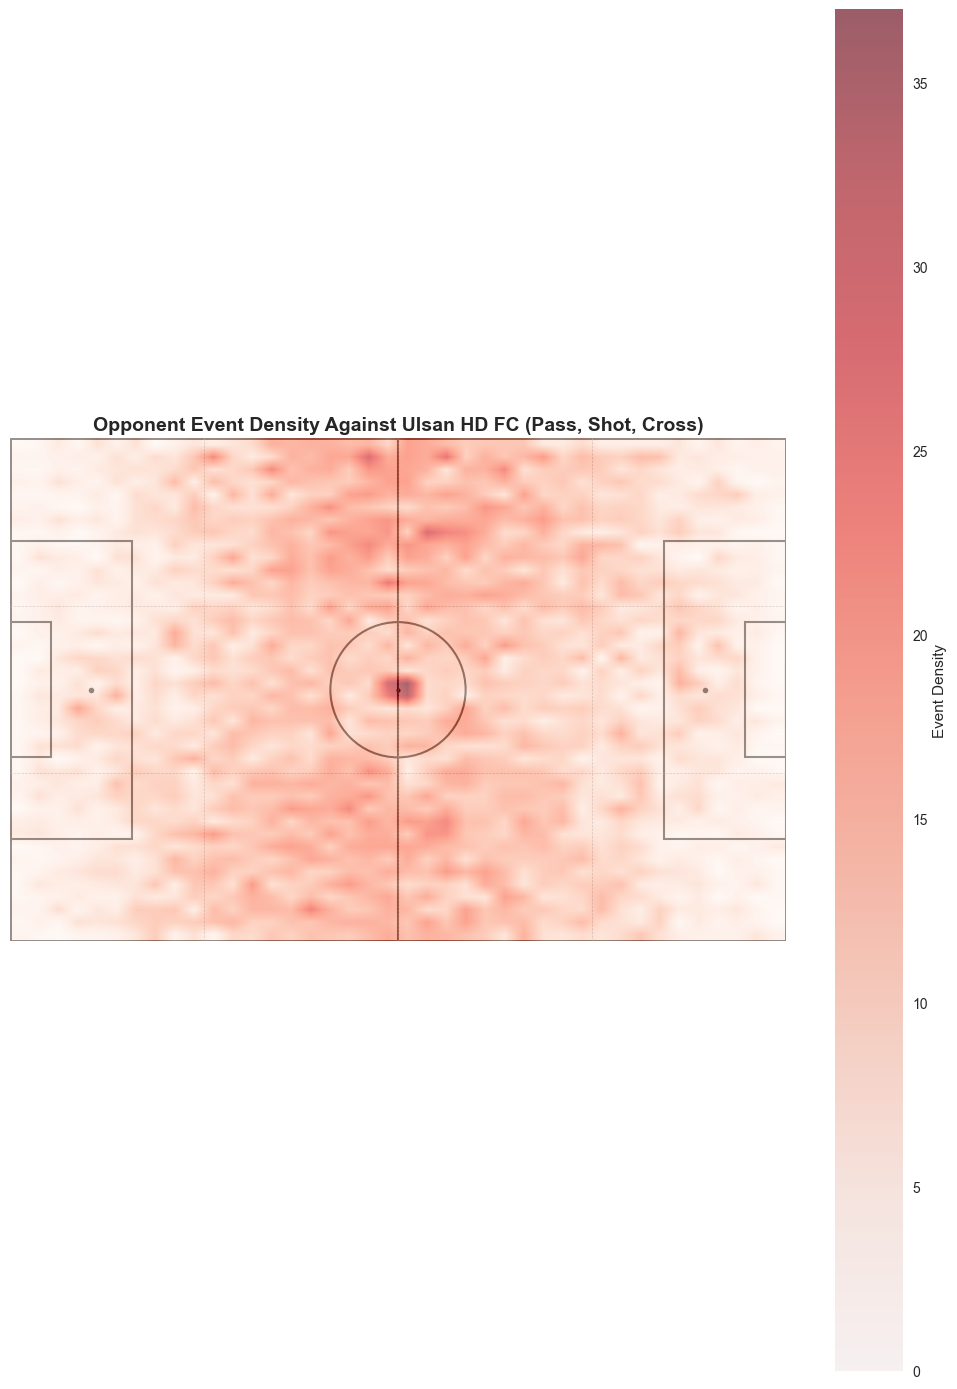

Total events in heatmap: 14315


In [75]:
# Opponent event density heatmap on pitch
if len(defense_events) > 0:
    from src.pitch_plot import draw_pitch, simple_kde_heatmap, add_zones_to_ax
    
    # Filter for key events
    key_events = defense_events[defense_events['type_name'].isin(['Pass', 'Shot', 'Cross'])].copy()
    
    # Remove NaN coordinates
    key_events_clean = key_events[
        key_events['start_x'].notna() & 
        key_events['start_y'].notna()
    ].copy()
    
    if len(key_events_clean) > 0:
        fig, ax = plt.subplots(figsize=(10, 14))
        draw_pitch(ax=ax, show=False)
        add_zones_to_ax(ax)
        
        # Ensure axes limits are set correctly
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        # Plot heatmap with better visibility
        ax = simple_kde_heatmap(
            key_events_clean,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            bins=40,
            cmap="Reds",  # Red for opponent attacks
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        
        # Ensure axes limits again after plotting
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        ax.set_title(f'Opponent Event Density Against {get_team_name_en(TARGET_TEAM)} (Pass, Shot, Cross)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"Total events in heatmap: {len(key_events_clean)}")
    else:
        print("No key events with valid coordinates found for heatmap.")
else:
    print("No defense events available.")


### 6. 상대팀 패스 시작 위치 히트맵


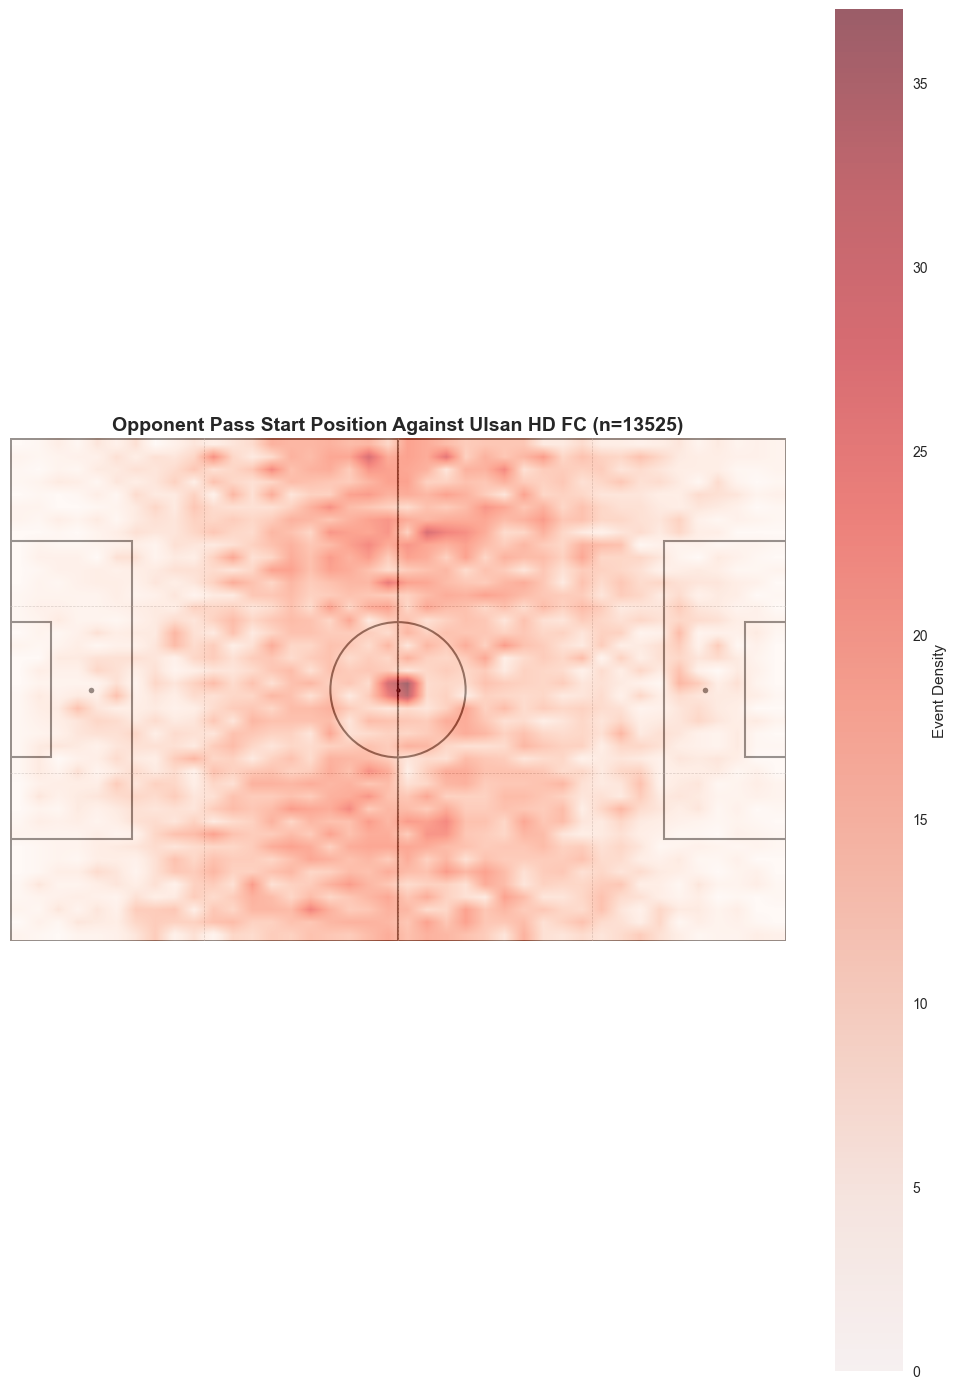

In [76]:
# Opponent pass start position heatmap on pitch
if len(defense_events) > 0:
    from src.pitch_plot import draw_pitch, simple_kde_heatmap, add_zones_to_ax
    
    # Filter for passes
    passes = defense_events[defense_events['type_name'] == 'Pass'].copy()
    
    # Remove NaN coordinates
    passes_clean = passes[
        passes['start_x'].notna() & 
        passes['start_y'].notna()
    ].copy()
    
    if len(passes_clean) > 0:
        fig, ax = plt.subplots(figsize=(10, 14))
        draw_pitch(ax=ax, show=False)
        add_zones_to_ax(ax)
        
        # Ensure axes limits are set correctly
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        # Plot heatmap
        ax = simple_kde_heatmap(
            passes_clean,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            bins=40,
            cmap="Reds",
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        
        # Ensure axes limits again after plotting
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        ax.set_title(f'Opponent Pass Start Position Against {get_team_name_en(TARGET_TEAM)} (n={len(passes_clean)})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("No passes with valid coordinates found.")
else:
    print("No defense events available.")


### 7. 상대팀 슛 위치 히트맵


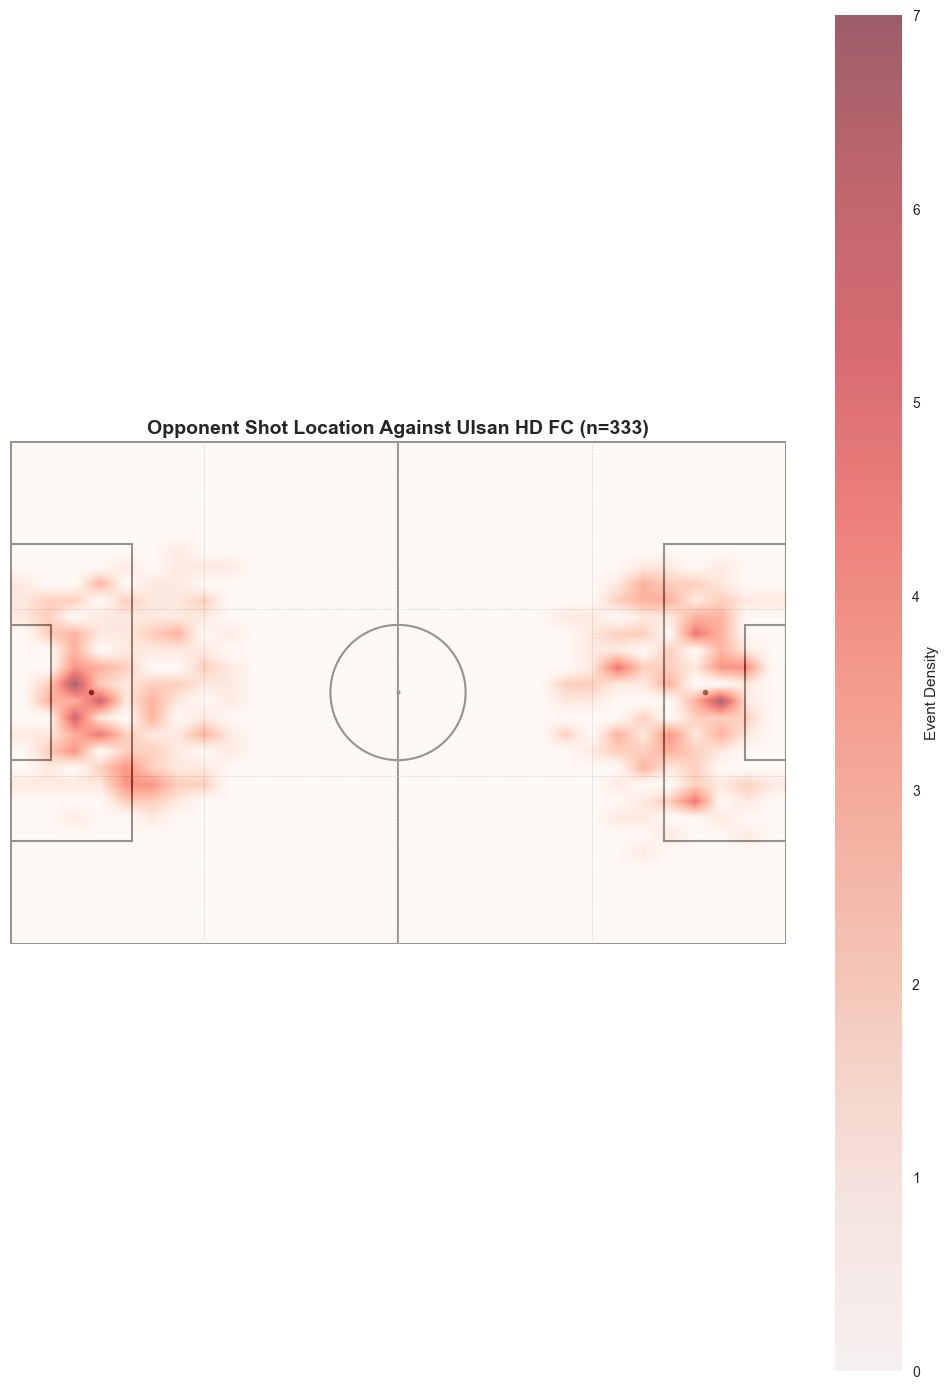

In [77]:
# Opponent shot location heatmap on pitch
if len(defense_events) > 0:
    from src.pitch_plot import draw_pitch, simple_kde_heatmap, add_zones_to_ax
    
    # Filter for shots
    shots = defense_events[defense_events['type_name'] == 'Shot'].copy()
    
    # Remove NaN coordinates
    shots_clean = shots[
        shots['start_x'].notna() & 
        shots['start_y'].notna()
    ].copy()
    
    if len(shots_clean) > 0:
        fig, ax = plt.subplots(figsize=(10, 14))
        draw_pitch(ax=ax, show=False)
        add_zones_to_ax(ax)
        
        # Ensure axes limits are set correctly
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        # Plot heatmap
        ax = simple_kde_heatmap(
            shots_clean,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            bins=30,
            cmap="Reds",
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        
        # Ensure axes limits again after plotting
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        ax.set_title(f'Opponent Shot Location Against {get_team_name_en(TARGET_TEAM)} (n={len(shots_clean)})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("No shots with valid coordinates found.")
else:
    print("No defense events available.")
